In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,RFE,f_regression
from sklearn.ensemble import ExtraTreesClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,label_binarize
import statsmodels.api as sm 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel

In [2]:
df = pd.read_csv('winequality-white.csv',sep=';') #Importing the dataset and creating the dataframe
df.describe() # Statistical Description of the dataframe
df1 = df


In [3]:
X = df.iloc[:,:11] #Various Feature parameters given in the dataset
Y = df.iloc[:,11:] #Quality Column

In [4]:
skb = SelectKBest(score_func=chi2,k=2) # This is K best function to identify the top 'k' features. Here k is 10.
fit = skb.fit(X,Y) 
scores = pd.DataFrame(fit.scores_)
columns = pd.DataFrame(X.columns)

featurescorecolumn = pd.concat([columns,scores],axis=1)
featurescorecolumn.columns=['Feature','Score']
print('This is feature selection using chi2 score function')
featurescorecolumn.nlargest(10,'Score')

This is feature selection using chi2 score function


,Feature,Score
6,total sulfur dioxide,3358.298433
5,free sulfur dioxide,947.712845
3,residual sugar,501.235224
10,alcohol,155.078234
1,volatile acidity,12.622636
0,fixed acidity,7.922042
4,chlorides,2.529005
2,citric acid,0.851118
9,sulphates,0.579206
8,pH,0.428745


In [5]:
skb1 = SelectKBest(score_func=f_regression,k=2) # This is K best function to identify the top 'k' features. Here k is 10.
fit = skb1.fit(X,Y) 
scores = pd.DataFrame(fit.scores_)
columns = pd.DataFrame(X.columns)

featurescorecolumn = pd.concat([columns,scores],axis=1)
featurescorecolumn.columns=['Feature','Score']
print('This is feature selection using F values score function')
featurescorecolumn.nlargest(10,'Score')

This is feature selection using F values score function


,Feature,Score
10,alcohol,1146.395496
7,density,509.911101
4,chlorides,225.727097
1,volatile acidity,192.958204
6,total sulfur dioxide,154.198182
0,fixed acidity,64.080465
8,pH,48.884022
3,residual sugar,47.064087
9,sulphates,14.147680
2,citric acid,0.415252


<AxesSubplot:>

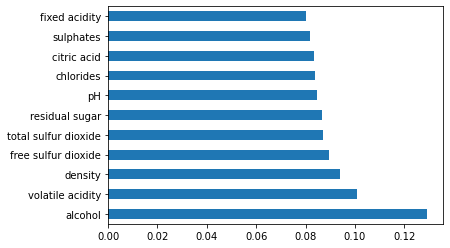

In [6]:
ETC = ExtraTreesClassifier() #This is the extratreesclassifier to understand the feature relationship of the given data
ETC.fit(X,Y)
featurescorecolumn1 = pd.Series(ETC.feature_importances_,index=X.columns)
featurescorecolumn1.nlargest(11).plot(kind='barh')

<AxesSubplot:>

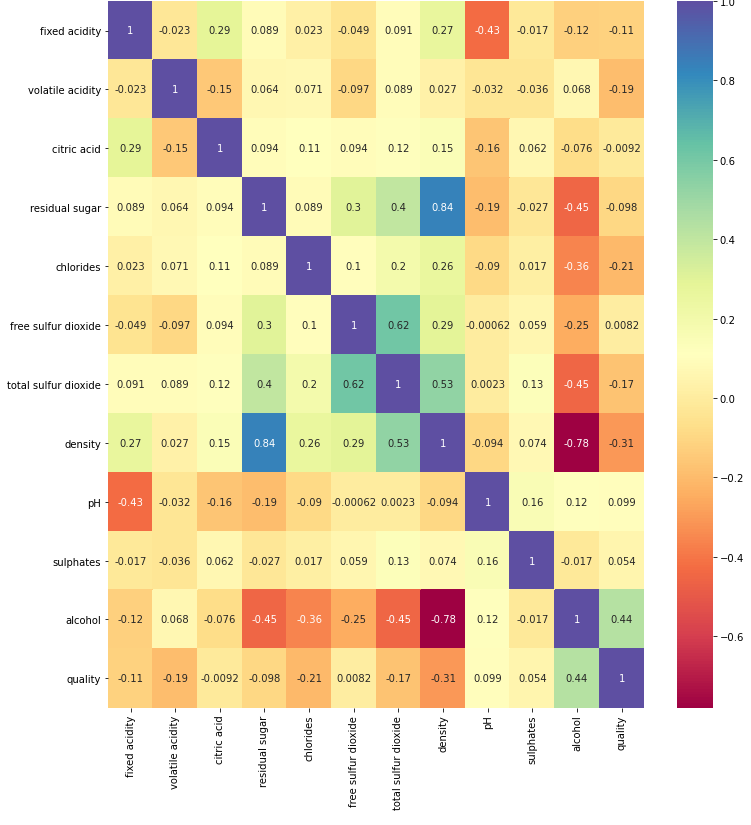

In [7]:
plt.figure(figsize=(12,13))
correlation = df.corr()
sns.heatmap(correlation,cmap='Spectral',annot=True) # Here We are finding the correaltion between different features of the dataset


In [8]:
#Relevant features from correlation matrix
relevant_features = abs(correlation['quality'])
relevant_features = relevant_features.nlargest(5)
relevant_features 


quality             1.000000
alcohol             0.435575
density             0.307123
chlorides           0.209934
volatile acidity    0.194723
Name: quality, dtype: float64

In [9]:
cols = list(X.columns)
pmax = 1
while(len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    m = sm.OLS(Y,X_1,missing=None).fit()
    p = pd.Series(m.pvalues.values[1:],index=cols)
    pmax = max(p)
    feature_with_pmax = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_pmax)
    else:
        break

print('This is the output for backward elimination using  the function Ordinary Least sqaure and p values ')
print(cols)
 # Sometimes it throws an SVD did not converge error. That happens because of having more eigenvalues as zero. You run this cell once or twice again and it will disappear and show you the results.


LinAlgError: SVD did not converge

In [10]:
logreg = LogisticRegression()
selector = RFE(logreg)
selector = selector.fit(X,Y)

selected_features = pd.DataFrame({'Feature':list(X.columns),'Ranking':selector.ranking_})
print('This is Recursive Feature elimination which uses the logistic regression function')
print(selected_features.sort_values(by='Ranking'))

This is Recursive Feature elimination which uses the logistic regression function
                 Feature  Ranking
0          fixed acidity        1
3         residual sugar        1
5    free sulfur dioxide        1
8                     pH        1
10               alcohol        1
6   total sulfur dioxide        2
1       volatile acidity        3
7                density        4
2            citric acid        5
9              sulphates        6
4              chlorides        7


In [11]:
lasso = SelectFromModel(logreg)
lasso.fit(X,Y)

lasso_support = lasso.get_support()
lasso_feature = X.loc[:,lasso_support].columns.tolist()
print('This is feature selection using lasso method')
print(list(lasso_feature))

This is feature selection using lasso method
['fixed acidity', 'alcohol']


## We have been using a scale of 0-10 for wine quality as the output. But now, we are gonna make a small change and convert it into three different categories Low, Medium and High instead of 10 scale classification. This will improve the results as the classification becomes easier.

In [12]:
quality = Y.values
new_quality = []
for i in quality:
    if i<5:
        new_quality.append('Low')
    elif i>7:
        new_quality.append('High')
    else:
        new_quality.append('Medium')

y = pd.DataFrame(new_quality,columns=['quality'])
#First we have used a three categories classification and then two categories classification . The accuracy score was pretty much the same

## We cannot use a string to find the feature relationship. So we are gonna use labelencoder to convert it to corresponding number to avoid the logical fallacy


In [13]:
le = LabelEncoder()
y = le.fit_transform(y)
y = pd.DataFrame(y,columns=['quality'])
df1['quality'] = y
y

,quality
0,2
1,2
2,2
3,2
4,2
...,...
4893,2
4894,2
4895,2
4896,2


## Now, implementing all the feature selection method again using new y label

In [14]:
fit1 = skb.fit(X,y)
scores1 = pd.DataFrame(fit1.scores_)
featurescorecolumn1 = pd.concat([columns,scores1],axis=1)
featurescorecolumn1.columns=['Feature','Score']
print('This is a feature selection using chi2 as score function with new y label')
print(featurescorecolumn1.nlargest(11,'Score'))

This is a feature selection using chi2 as score function with new y label
                 Feature       Score
5    free sulfur dioxide  410.232327
6   total sulfur dioxide  312.137820
3         residual sugar   93.232117
10               alcohol   24.571241
1       volatile acidity    6.535657
0          fixed acidity    3.681390
2            citric acid    0.426922
4              chlorides    0.329732
9              sulphates    0.083390
8                     pH    0.064225
7                density    0.000630


In [15]:
fit1 = skb1.fit(X,y)
scores1 = pd.DataFrame(fit1.scores_)
featurescorecolumn1 = pd.concat([columns,scores1],axis=1)
featurescorecolumn1.columns=['Feature','Score']
print('This is a feature selection using F values function as score function with new y label')
print(featurescorecolumn1.nlargest(11,'Score'))

This is a feature selection using F values function as score function with new y label
                 Feature      Score
10               alcohol  96.116223
7                density  47.386969
1       volatile acidity  37.235522
6   total sulfur dioxide  23.596167
3         residual sugar  14.612367
4              chlorides   9.163241
8                     pH   6.247507
5    free sulfur dioxide   5.079368
2            citric acid   3.990288
9              sulphates   1.492056
0          fixed acidity   0.024688


<AxesSubplot:>

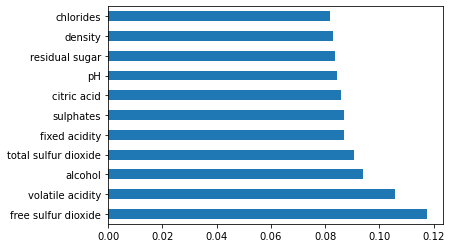

In [16]:
ETC.fit(X,y)
featurescorecolumn1_1 = pd.Series(ETC.feature_importances_,index=X.columns)
featurescorecolumn1_1.nlargest(11).plot(kind='barh')

<AxesSubplot:>

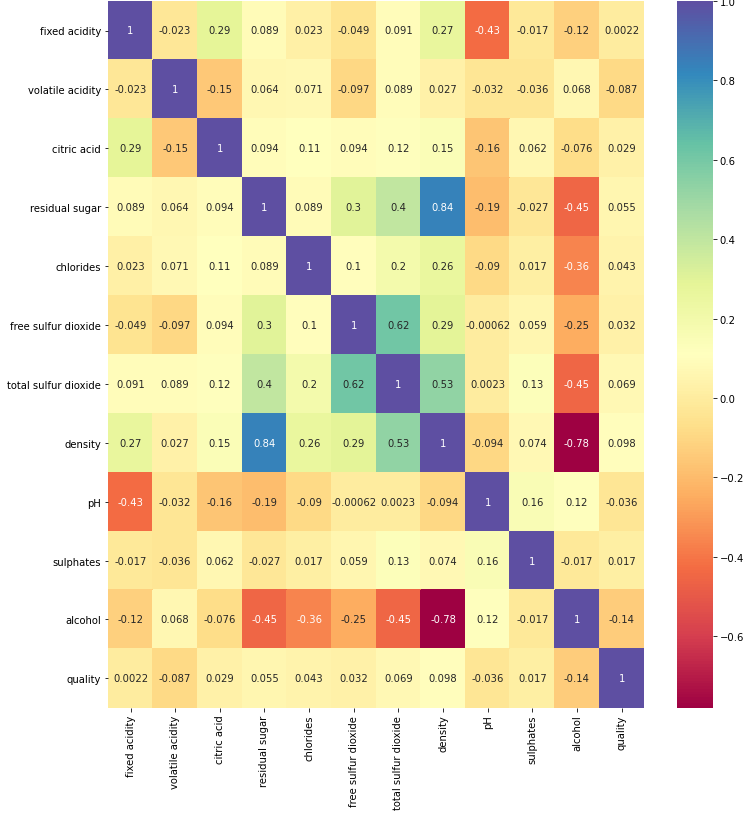

In [17]:
plt.figure(figsize=(12,13))
correlation = df1.corr()
sns.heatmap(correlation,cmap='Spectral',annot=True)

In [18]:
relevant_features = abs(correlation['quality'])
relevant_features = relevant_features.nlargest(5)
relevant_features 

quality                 1.000000
alcohol                 0.138757
density                 0.097908
volatile acidity        0.086879
total sulfur dioxide    0.069256
Name: quality, dtype: float64

In [19]:
#Backward Elimination method
cols1 = list(X.columns)
pmax = 1
while(len(cols1)>0):
    p = []
    X_1 = X[cols1]
    X_1 = sm.add_constant(X_1)
    m1 = sm.OLS(y,X_1,missing=None).fit()
    p = pd.Series(m1.pvalues.values[1:],index=cols1)
    pmax = max(p)
    feature_with_pmax = p.idxmax()
    if(pmax>0.05):
        cols1.remove(feature_with_pmax)
    else:
        break
print('This is Backward elimination using Ordinary Least square and p values with new y label')
print(cols1)
# Sometimes it throws an SVD did not converge error. That happens because of having more eigenvalues as zero. You run this cell once or twice again and it will disappear and show you the results.

LinAlgError: SVD did not converge

In [20]:
logreg = LogisticRegression()
selector = RFE(logreg)
selector = selector.fit(X,y)

selected_features = pd.DataFrame({'Feature':list(X.columns),'Ranking':selector.ranking_})
selected_features.sort_values(by='Ranking')

,Feature,Ranking
1,volatile acidity,1
7,density,1
8,pH,1
9,sulphates,1
10,alcohol,1
2,citric acid,2
0,fixed acidity,3
4,chlorides,4
3,residual sugar,5
5,free sulfur dioxide,6


In [59]:
lasso = SelectFromModel(logreg)
lasso.fit(X,y)

lasso_support = lasso.get_support()
lasso_feature = X.loc[:,lasso_support].columns.tolist()
print('This is feature selection using lasso method with new y label')
print(list(lasso_feature))

This is feature selection using lasso method with new y label
['fixed acidity', 'volatile acidity', 'pH', 'alcohol']


## We have completed the feature selection methods using two different quality scales and have come to a conclusion that alcohol, volatile acidity and density are the three most important feature that determine the quality of wine.

In [22]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=117) # Splitting the dataset into training and testing frames

In [23]:
sc= StandardScaler() # Using the standard scaler function to normalize the function
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [24]:
classifier1 = svm.SVC(kernel='rbf',probability=True)
classifier1 = CalibratedClassifierCV(classifier1)
classifier1 = OneVsRestClassifier(classifier1)
classifier1.fit(X_train,Y_train)
Y_pred = classifier1.predict(X_test)
acc = metrics.accuracy_score(Y_pred,Y_test)
print('Accuracy score using svm classifier is {:0.2f}%'.format(acc*100))
#print('Senstivity score using svm classifier is {:0.2f}'.format(sensitivity_score(Y_pred,Y_test)))

Accuracy score using svm classifier is 57.24%


<AxesSubplot:>

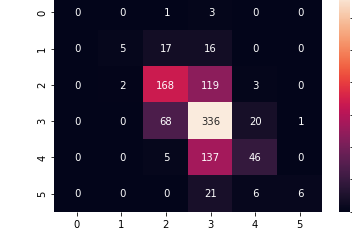

In [25]:
cm = confusion_matrix(Y_test,Y_pred)
sns.heatmap(cm,annot=True,fmt='2.0f')

In [26]:
report = metrics.classification_report(Y_test,Y_pred) 
print("Classification report for Decision Tree classifier is: \n",report)

Classification report for Decision Tree classifier is: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.71      0.13      0.22        38
           5       0.65      0.58      0.61       292
           6       0.53      0.79      0.64       425
           7       0.61      0.24      0.35       188
           8       0.86      0.18      0.30        33

    accuracy                           0.57       980
   macro avg       0.56      0.32      0.35       980
weighted avg       0.60      0.57      0.54       980



ROC curve for different y labels shown in the same graph with area under the graph as legend
ipykernel_launcher:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


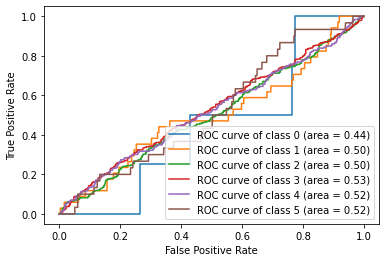

In [27]:
fpr=dict()
tpr=dict()
roc_auc=dict()
Y1 = label_binarize(Y,classes=[3,4,5,6,7,8])
Y1_train,Y1_test = train_test_split(Y1,test_size=0.2)
Y_score=classifier1.fit(X_train,Y1_train).predict_proba(X_test)
for i in range(Y1.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Y1_test[:,i], Y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#fig = plt.figure()
#fig.add_subplot(1,2,1)
#plt.plot(fpr[1],tpr[1],label='ROC curve (area=%0.2f)'%roc_auc[1])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.legend(loc='lower right')
#plt.show()
#fig.add_subplot(1,2,1)
#plt.plot(fpr[2],tpr[2],label='ROC curve (area=%0.2f)'%roc_auc[2])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.legend(loc='lower right')
#plt.show()
print('ROC curve for different y labels shown in the same graph with area under the graph as legend')
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(Y1.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(Y1.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
plt.figure()
for i in range(Y1.shape[1]):
    plt.plot(fpr[i],tpr[i],label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [28]:
y_train,y_test = train_test_split(y,test_size=0.2,random_state=117) # Redefined quality values

In [29]:
classifier1.fit(X_train,y_train)
y_pred = classifier1.predict(X_test)
acc = metrics.accuracy_score(y_pred,y_test)
print('Accuracy score of redefined quality values using svm classifier is {:0.2f}%'.format(acc*100))

Accuracy score of redefined quality values using svm classifier is 92.55%


<AxesSubplot:>

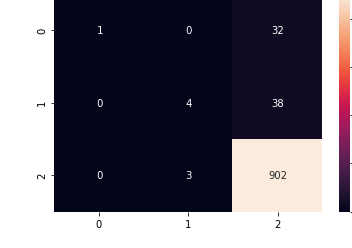

In [30]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='2.0f')

In [31]:
report = metrics.classification_report(y_test,y_pred) 
print("Classification report for Decision Tree classifier is: \n",report)

Classification report for Decision Tree classifier is: 
               precision    recall  f1-score   support

           0       1.00      0.03      0.06        33
           1       0.57      0.10      0.16        42
           2       0.93      1.00      0.96       905

    accuracy                           0.93       980
   macro avg       0.83      0.37      0.39       980
weighted avg       0.92      0.93      0.90       980



ROC curve for different y labels shown in the same graph with area under the graph as legend
ipykernel_launcher:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


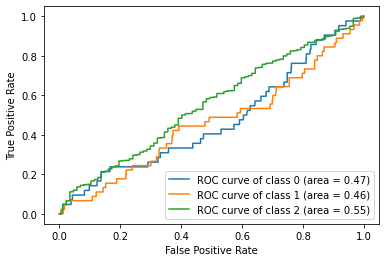

In [32]:
fpr=dict()
tpr=dict()
roc_auc=dict()
y1 = label_binarize(y,classes=[0,1,2])
y1_train,y1_test = train_test_split(y1,test_size=0.2)
y_score = classifier1.fit(X_train,y1_train).predict_proba(X_test)
for i in range(y1.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y1_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print('ROC curve for different y labels shown in the same graph with area under the graph as legend')
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y1.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(y1.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
plt.figure()
for i in range(y1.shape[1]):
    plt.plot(fpr[i],tpr[i],label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## We can see a surge in the accuracy score when we used the redefined quality values for mine. This is because of the decrease in number of classifications. i.e From 0-10 to 0 to 2.

In [33]:
classifier2 = GaussianNB()
classifier2 = OneVsRestClassifier(classifier2)
classifier2.fit(X_train,Y_train)
Y_pred = classifier2.predict(X_test)
acc = metrics.accuracy_score(Y_pred,Y_test)
print('Accuracy score using Naive Bayes Gaussian classifier is {:0.2f}%'.format(acc*100))


Accuracy score using Naive Bayes Gaussian classifier is 48.16%


<AxesSubplot:>

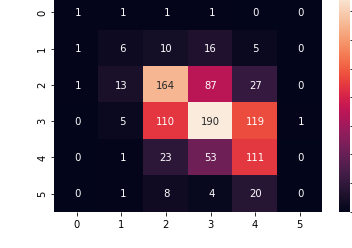

In [34]:
cm = confusion_matrix(Y_test,Y_pred)
sns.heatmap(cm,annot=True,fmt='2.0f')


In [35]:
report = metrics.classification_report(Y_test,Y_pred) 
print("Classification report for Decision Tree classifier is: \n",report)

Classification report for Decision Tree classifier is: 
               precision    recall  f1-score   support

           3       0.33      0.25      0.29         4
           4       0.22      0.16      0.18        38
           5       0.52      0.56      0.54       292
           6       0.54      0.45      0.49       425
           7       0.39      0.59      0.47       188
           8       0.00      0.00      0.00        33

    accuracy                           0.48       980
   macro avg       0.33      0.33      0.33       980
weighted avg       0.47      0.48      0.47       980



ROC curve for different y labels shown in the same graph with area under the graph as legend
ipykernel_launcher:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


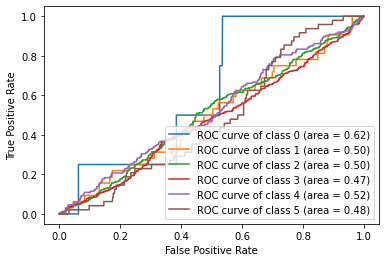

In [36]:
fpr=dict()
tpr=dict()
roc_auc=dict()
Y1 = label_binarize(Y,classes=[3,4,5,6,7,8])
Y1_train,Y1_test = train_test_split(Y1,test_size=0.2)
Y_score=classifier2.fit(X_train,Y1_train).predict_proba(X_test)
for i in range(Y1.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Y1_test[:,i], Y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print('ROC curve for different y labels shown in the same graph with area under the graph as legend')
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(Y1.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(Y1.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
plt.figure()
for i in range(Y1.shape[1]):
    plt.plot(fpr[i],tpr[i],label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [37]:
classifier2.fit(X_train,y_train)
y_pred = classifier2.predict(X_test)
acc = metrics.accuracy_score(y_pred,y_test)
print('Accuracy score of redefined quality values using Naive Bayes Gaussian classifier is {:0.2f}%'.format(acc*100))

Accuracy score of redefined quality values using Naive Bayes Gaussian classifier is 90.20%


<AxesSubplot:>

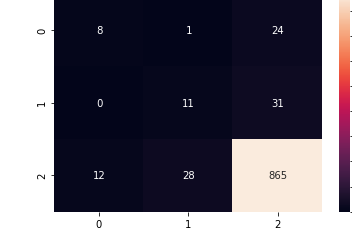

In [38]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='2.0f')

In [39]:
report = metrics.classification_report(y_test,y_pred) 
print("Classification report for Decision Tree classifier is: \n",report)

Classification report for Decision Tree classifier is: 
               precision    recall  f1-score   support

           0       0.40      0.24      0.30        33
           1       0.28      0.26      0.27        42
           2       0.94      0.96      0.95       905

    accuracy                           0.90       980
   macro avg       0.54      0.49      0.51       980
weighted avg       0.89      0.90      0.90       980



ROC curve for different y labels shown in the same graph with area under the graph as legend
ipykernel_launcher:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


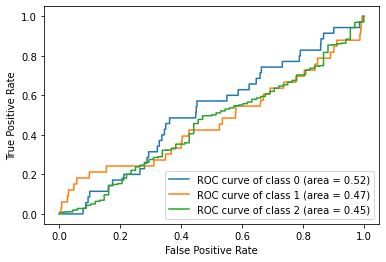

In [40]:
fpr=dict()
tpr=dict()
roc_auc=dict()
y1 = label_binarize(y,classes=[0,1,2])
y1_train,y1_test = train_test_split(y1,test_size=0.2)
y_score = classifier2.fit(X_train,y1_train).predict_proba(X_test)
for i in range(y1.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y1_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print('ROC curve for different y labels shown in the same graph with area under the graph as legend')
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y1.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(y1.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
plt.figure()
for i in range(y1.shape[1]):
    plt.plot(fpr[i],tpr[i],label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [41]:
classifier3 = KNeighborsClassifier()
classifier3 = OneVsRestClassifier(classifier3)
classifier3.fit(X_train,Y_train)
Y_pred = classifier3.predict(X_test)
acc = metrics.accuracy_score(Y_pred,Y_test)
print('Accuracy score using KNeighbors classifier is {0:.2f}% '.format(acc*100))


Accuracy score using KNeighbors classifier is 55.41% 


<AxesSubplot:>

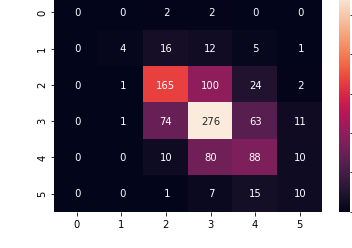

In [42]:
cm = confusion_matrix(Y_test,Y_pred)
sns.heatmap(cm,annot=True,fmt='2.0f')

In [43]:
report = metrics.classification_report(Y_test,Y_pred) 
print("Classification report for Decision Tree classifier is: \n",report)

Classification report for Decision Tree classifier is: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.67      0.11      0.18        38
           5       0.62      0.57      0.59       292
           6       0.58      0.65      0.61       425
           7       0.45      0.47      0.46       188
           8       0.29      0.30      0.30        33

    accuracy                           0.55       980
   macro avg       0.43      0.35      0.36       980
weighted avg       0.56      0.55      0.55       980



ROC curve for different y labels shown in the same graph with area under the graph as legend
ipykernel_launcher:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


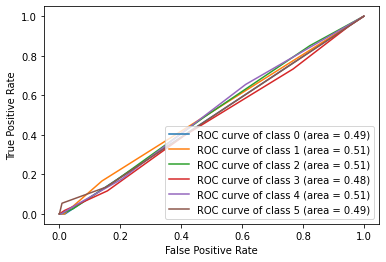

In [44]:
fpr=dict()
tpr=dict()
roc_auc=dict()
Y1 = label_binarize(Y,classes=[3,4,5,6,7,8])
Y1_train,Y1_test = train_test_split(Y1,test_size=0.2)
Y_score=classifier3.fit(X_train,Y1_train).predict_proba(X_test)
for i in range(Y1.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Y1_test[:,i], Y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print('ROC curve for different y labels shown in the same graph with area under the graph as legend')
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(Y1.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(Y1.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
plt.figure()
for i in range(Y1.shape[1]):
    plt.plot(fpr[i],tpr[i],label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [45]:
classifier3.fit(X_train,y_train)
y_pred = classifier3.predict(X_test)
acc = metrics.accuracy_score(y_pred,y_test)
print('Accuracy score of redefined quality values using KNeighbors Classifier is {:0.2f}% '.format(acc*100))

Accuracy score of redefined quality values using KNeighbors Classifier is 92.14% 


<AxesSubplot:>

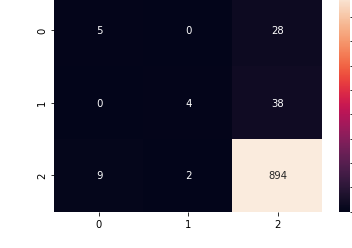

In [46]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='2.0f')

In [47]:
report = metrics.classification_report(y_test,y_pred) 
print("Classification report for Decision Tree classifier is: \n",report)

Classification report for Decision Tree classifier is: 
               precision    recall  f1-score   support

           0       0.36      0.15      0.21        33
           1       0.67      0.10      0.17        42
           2       0.93      0.99      0.96       905

    accuracy                           0.92       980
   macro avg       0.65      0.41      0.45       980
weighted avg       0.90      0.92      0.90       980



ROC curve for different y labels shown in the same graph with area under the graph as legend
ipykernel_launcher:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


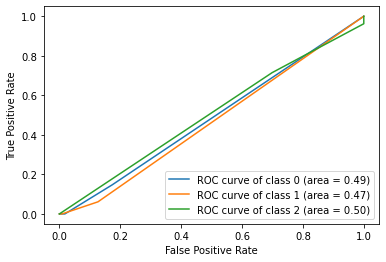

In [48]:
fpr=dict()
tpr=dict()
roc_auc=dict()
y1 = label_binarize(y,classes=[0,1,2])
y1_train,y1_test = train_test_split(y1,test_size=0.2)
y_score = classifier3.fit(X_train,y1_train).predict_proba(X_test)
for i in range(y1.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y1_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print('ROC curve for different y labels shown in the same graph with area under the graph as legend')
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y1.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(y1.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
plt.figure()
for i in range(y1.shape[1]):
    plt.plot(fpr[i],tpr[i],label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [49]:
classifier4 = DecisionTreeClassifier()
classifier4 = OneVsRestClassifier(classifier4)
classifier4.fit(X_train,Y_train)
Y_pred = classifier4.predict(X_test)
acc = metrics.accuracy_score(Y_pred,Y_test)
print('Accuracy score using Decision Tree classifier is {:0.2f}%'.format(acc*100))

Accuracy score using Decision Tree classifier is 53.67%


<AxesSubplot:>

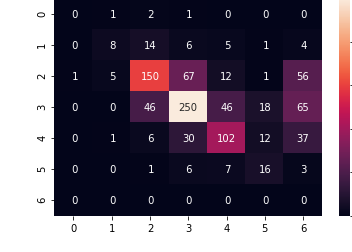

In [50]:
cm = confusion_matrix(Y_test,Y_pred)
sns.heatmap(cm,annot=True,fmt='2.0f')

In [51]:
report = metrics.classification_report(Y_test,Y_pred) 
print("Classification report for Decision Tree classifier is: \n",report)

Classification report for Decision Tree classifier is: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.53      0.21      0.30        38
           5       0.68      0.51      0.59       292
           6       0.69      0.59      0.64       425
           7       0.59      0.54      0.57       188
           8       0.33      0.48      0.40        33
           9       0.00      0.00      0.00         0

    accuracy                           0.54       980
   macro avg       0.41      0.33      0.36       980
weighted avg       0.65      0.54      0.58       980



ROC curve for different y labels shown in the same graph with area under the graph as legend
ipykernel_launcher:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


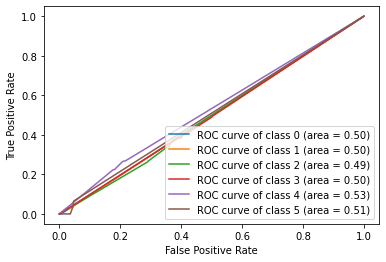

In [52]:
fpr=dict()
tpr=dict()
roc_auc=dict()
Y1 = label_binarize(Y,classes=[3,4,5,6,7,8])
Y1_train,Y1_test = train_test_split(Y1,test_size=0.2)
Y_score=classifier4.fit(X_train,Y1_train).predict_proba(X_test)
for i in range(Y1.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Y1_test[:,i], Y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print('ROC curve for different y labels shown in the same graph with area under the graph as legend')
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(Y1.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(Y1.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
plt.figure()
for i in range(Y1.shape[1]):
    plt.plot(fpr[i],tpr[i],label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [53]:
classifier4.fit(X_train,y_train)
y_pred = classifier4.predict(X_test)
acc = metrics.accuracy_score(y_pred,y_test)
print('Accuracy score for predefined quality values using Decision Trees classifier is {:0.2f}% '.format(acc*100))

Accuracy score for predefined quality values using Decision Trees classifier is 93.98% 


<AxesSubplot:>

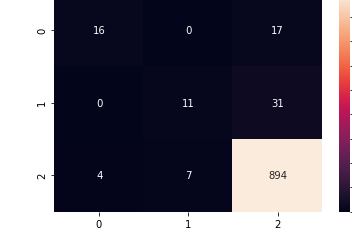

In [54]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='2.0f')

In [55]:
report = metrics.classification_report(y_test,y_pred) 
print("Classification report for Decision Tree classifier is: \n",report)

Classification report for Decision Tree classifier is: 
               precision    recall  f1-score   support

           0       0.80      0.48      0.60        33
           1       0.61      0.26      0.37        42
           2       0.95      0.99      0.97       905

    accuracy                           0.94       980
   macro avg       0.79      0.58      0.65       980
weighted avg       0.93      0.94      0.93       980



ROC curve for different y labels shown in the same graph with area under the graph as legend
ipykernel_launcher:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


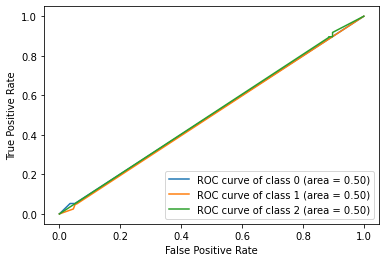

In [56]:
fpr=dict()
tpr=dict()
roc_auc=dict()
y1 = label_binarize(y,classes=[0,1,2])
y1_train,y1_test = train_test_split(y1,test_size=0.2)
y_score = classifier4.fit(X_train,y1_train).predict_proba(X_test)
for i in range(y1.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y1_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print('ROC curve for different y labels shown in the same graph with area under the graph as legend')
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y1.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(y1.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
plt.figure()
for i in range(y1.shape[1]):
    plt.plot(fpr[i],tpr[i],label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()